### <font color="orange">Edtech: описание кейса</font>

📝 В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. Эксперимент проводился с помощью A/B–тестирования.

**Задача: проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.**  

Предлагается ответить на следующие вопросы:  

1. На какие метрики вы смотрите в ходе анализа и почему?
2. Имеются ли различия в показателях и с чем они могут быть связаны?
3. Являются ли эти различия статистически значимыми?
4. Стоит ли запускать новую механику на всех пользователей?


**Дополнительные задачи:**
1. Реализовать функцию, которая будет автоматически подгружать информацию из доп. файла и на основании доп. параметров пересчитывать метрики.
2. Реализовать функцию, которая будет строить графики по получаемым метрикам.

### <font color="orange">Edtech: решение кейса</font>

**Ознакомимся с файлами для загрузки (файлы хранятся на Яндекс.Диске):**

<font color="blue">**groups.csv**</font> – файл с данными о принадлежности пользователя к группе (А – контрольная, B – целевая)    
<font color="blue">**groups_add.csv**</font> – доп. файл с пользователями, который прислали спустя 2 дня после передачи данных  
<font color="blue">**active_studs.csv**</font> – файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента  
<font color="blue">**checks.csv**</font> – файл с информацией об оплатах пользователей в дни проведения эксперимента  


### Задание 1. A/B–тестирование

**EDA**

#### Настройка API подключения и загрузка данных

In [107]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(10,4)}, style="whitegrid")

import scipy.stats as st
import pingouin as pg

import requests
from urllib.parse import urlencode

In [8]:
# Напишем функцию для чтения файлов с Яндекс-диска и получим загрузочные ссылки
def func_for_download_url(public_key_for_table, base_url='https://cloud-api.yandex.net/v1/disk/public/resources/download?'):
    final_url = base_url + urlencode(dict(public_key=public_key_for_table))
    response = requests.get(final_url)
    return response.json()['href']

download_url_groups        = func_for_download_url('https://disk.yandex.ru/d/UhyYx41rTt3clQ')
download_url_groups_add    = func_for_download_url('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ')
download_url_active_studs  = func_for_download_url('https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ')
download_url_checks        = func_for_download_url('https://disk.yandex.ru/d/pH1q-VqcxXjsVA')

In [9]:
# Создаем датафреймы
# принадлежность пользователя к контрольной или экспериментальной группе (основной файл)
groups = pd.read_csv(download_url_groups, sep=';')

# принадлежность пользователя к контрольной или экспериментальной группе (доп. файл)
groups_add = pd.read_csv(download_url_groups_add)

# информация о пользователях, которые зашли на платформу в дни проведения эксперимента
active_studs = pd.read_csv(download_url_active_studs)

# информация об оплатах пользователей в дни проведения эксперимента
checks = pd.read_csv(download_url_checks, sep=';')

#### groups

In [11]:
# А – контроль, B – целевая группа
groups.head(3)

,id,grp
0,1489,B
1,1627,A
2,1768,B


In [12]:
# Проверяем размер df, тип данных и наличие пустых значений
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [13]:
# Проверяем наличие дубликатов
groups.loc[groups.duplicated()]

,id,grp


In [14]:
# Проверяем уникальность 
groups.nunique()

id     74484
grp        2
dtype: int64

In [17]:
# Переводим в строковый тип данных поле с id
groups['id'] = groups['id'].astype(str)
groups.dtypes

id     object
grp    object
dtype: object

#### groups_add

In [19]:
# А – контроль, B – целевая группа
groups_add.head(3)

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B


In [20]:
# Проверяем размер df, тип данных и наличие пустых значений
groups_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [21]:
# Проверяем наличие дубликатов
groups_add.loc[groups_add.duplicated()]

,id,grp


In [22]:
# Проверяем уникальность 
groups_add.nunique()

id     92
grp     2
dtype: int64

In [23]:
# Переводим в строковый тип данных поле с id
groups_add['id'] = groups_add['id'].astype(str)
groups_add.dtypes

id     object
grp    object
dtype: object

#### active_studs

In [28]:
active_studs.head(3)

,student_id
0,581585
1,5723133
2,3276743


In [29]:
# Проверяем размер df, тип данных, уникальность, наличие пустых значений
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [30]:
active_studs.nunique()

student_id    8341
dtype: int64

In [31]:
# Переводим в строковый тип данных поле с id
active_studs['student_id'] = active_studs['student_id'].astype(str)
active_studs.dtypes

student_id    object
dtype: object

####  checks

In [32]:
checks.head(3)

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0


In [33]:
# Проверяем размер df, тип данных, уникальность, наличие пустых значений
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [34]:
checks.nunique()

student_id    541
rev            39
dtype: int64

In [35]:
# Переводим в строковый тип данных поле с id
checks['student_id'] = checks['student_id'].astype(str)

In [37]:
# Посмотрим на описательные статистики колонки с выручкой
checks.describe()

,rev
count,541.000000
mean,1059.752317
std,762.712359
min,199.000000
25%,290.000000
50%,840.000000
75%,1900.000000
max,4650.000000


In [38]:
# Посмотрим, какие данные содержатся в колонке с выручкой
checks.rev.value_counts()

1900.0000    97
290.0000     94
690.0000     78
199.0000     46
990.0000     41
1900.0001    36
840.0000     27
1140.0000    25
580.0000     15
590.0000     11
398.0000      9
1530.0000     8
870.0000      6
3660.0000     5
1980.0000     4
2890.0000     4
2910.0000     4
489.0000      3
1160.0000     3
2099.0000     3
2820.0000     2
1180.0000     2
2220.0000     2
2900.0000     1
1830.0000     1
597.0000      1
1339.0000     1
1968.0000     1
1050.0000     1
630.0000      1
1729.0000     1
1388.0000     1
2190.0000     1
4650.0000     1
796.0000      1
3040.0000     1
880.0000      1
3260.0000     1
1039.0000     1
Name: rev, dtype: int64

In [39]:
# Посмотрим на дробную часть чисел, хранящихся в колонке rev
print(checks.rev.apply(lambda x: str(x).split('.')[-1]).unique()) 

['0' '0001']


In [40]:
# Приведем данные в колонке rev в формат int
checks['rev'] = checks['rev'].astype(int)

In [41]:
checks.dtypes

student_id    object
rev            int32
dtype: object

In [43]:
checks.nunique()

student_id    541
rev            38
dtype: int64

#### groups & groups_add  & active_studs & checks

In [49]:
# Проверим, нет ли пересечений по id в основном и дополнительном df
set(groups.id).intersection(groups_add.id)

set()

In [50]:
# Объединим df groups & groups_add
groups_all = pd.concat([groups, groups_add], ignore_index=True)
groups_all

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74571,200247820,B
74572,201032527,B
74573,201067612,B
74574,201067653,B


In [51]:
# Объединим df groups_all с данными о пользователях active_studs, которые зашли на платформу в дни проведения эксперимента 
groups_all = groups_all.merge(active_studs, how='left', left_on='id', right_on='student_id') \
                       .rename(columns={'student_id':'status'})
groups_all.tail(3)

,id,grp,status
74573,201067612,B,NaN
74574,201067653,B,NaN
74575,201067659,B,NaN


In [52]:
# Присвоим более очевидный статус активности
groups_all['status'] = groups_all['status'].apply(lambda x: 'inactive' if pd.isna(x) else 'active')
groups_all.tail(3)

,id,grp,status
74573,201067612,B,inactive
74574,201067653,B,inactive
74575,201067659,B,inactive


In [53]:
# Подтянем из checks информацию об оплатах пользователей в дни проведения эксперимента
groups_all = groups_all.merge(checks, how='left', left_on='id', right_on='student_id').drop(columns='student_id')
groups_all.tail(3)

,id,grp,status,rev
74573,201067612,B,inactive,NaN
74574,201067653,B,inactive,NaN
74575,201067659,B,inactive,NaN


In [54]:
# Присвоим более очевидный статус по оплатам
groups_all['client'] = groups_all['rev'].apply(lambda x: 'without paying' if pd.isna(x) else 'paying')

In [55]:
# Посмотрим на основные сводные данные: кол-во юзеров и платящих клиентов в абс. и относит. знач. по группам
groups_all.groupby(['grp'], as_index=False) \
          .agg(users=('id', 'count'), clients=('rev', 'count')) \
          .assign(users_p=lambda x: (x.users / x.users.sum() * 100).round(2)) \
          .assign(clients_p=lambda x: (x.clients / x.clients.sum() * 100).round(2))    

,grp,users,clients,users_p,clients_p
0,A,14693,107,19.7,19.78
1,B,59883,434,80.3,80.22


In [56]:
# Кол-во юзеров и платящих клиентов в абс. и относит. знач. по статусам активности в группе контроля
groups_all.query('grp == "A"').groupby(['status'], as_index=False) \
          .agg(users=('id', 'count'), clients=('rev', 'count')) \
          .assign(users_d=lambda x: (x.users / x.users.sum() * 100).round(2)) \
          .assign(clients_d=lambda x: (x.clients / x.clients.sum() * 100).round(2))

,status,users,clients,users_d,clients_d
0,active,1538,78,10.47,72.9
1,inactive,13155,29,89.53,27.1


In [57]:
# Кол-во юзеров и платящих клиентов в абс. и относит. знач. по статусам активности в группе теста
groups_all.query('grp == "B"').groupby(['status'], as_index=False) \
          .agg(users=('id', 'count'), clients=('rev', 'count')) \
          .assign(users_d=  lambda x: (x.users / x.users.sum() * 100).round(2)) \
          .assign(clients_d=lambda x: (x.clients / x.clients.sum() * 100).round(2))

,status,users,clients,users_d,clients_d
0,active,6803,314,11.36,72.35
1,inactive,53080,120,88.64,27.65


In [59]:
# Общая информация с расчетом основных показателей
groups_summary = groups_all.groupby(['grp', 'status'], as_index=False) \
                           .agg(users=('id', 'count'), clients=('rev', 'count'), rev_total=('rev','sum')) \
                           .assign(CR=lambda x: x.clients / x.users, ARPU=lambda x: x.rev_total / x.users, 
                                   ARPPU=lambda x: x.rev_total / x.clients) \
                           .sort_values('status')
groups_summary

,grp,status,users,clients,rev_total,CR,ARPU,ARPPU
0,A,active,1538,78,72820.0,0.050715,47.347204,933.589744
2,B,active,6803,314,394974.0,0.046156,58.058798,1257.878981
1,A,inactive,13155,29,19276.0,0.002204,1.465298,664.689655
3,B,inactive,53080,120,86256.0,0.002261,1.625019,718.800000


Кажется странным, что в обеих группах имеются пользователи, которые не заходили на платформу в дни проведения эксперимента, при этом по ним есть данные об оплатах. Вероятно, пользователи уже получали ранее ссылки на оплату (или, к примеру, сработало автопродление подписки), и для финального проведения оплаты не требовалось заходить на платформу.

### Проверка гипотез

####  Какие метрики наиболее подходят для анализа?

Цель A/B-теста — оценить влияние новой механики оплаты услуг на сайте. Кажется логичным, что только пользователи, которые посещали платформу в дни проведения эксперимента (status 'active'), могли взаимодействовать с изменениями и принять решение оплатить услуги на основе новой механики. Соответственно ключевыми метриками по эксперименту будем считать метрики, рассчитанные только по активным пользователям:    

- конверсия в оплату
- ARPU
- ARPPU

**Какие метрики не являются релевантными для задачи по оценке эффективности новой механики оплаты на сайте?**

Те же метрики, рассчитанные также и по неактивным пользователям.

**На какие второстепенные метрики стоит обратить внимание?**

- конверсия в посещаемость платформы

Несмотря на то, что прямого отношения к к исследуемому вопросу эта метрика не имеет, все же стоит обратить внимание на долю активных посетителей платформы от всех пользователей по группам, чтобы понять, не сломали ли мы с помощью нововведений привычную функциональность сайта:

In [60]:
display(pd.crosstab(groups_all.status, groups_all.grp, normalize='columns').round(4))

grp,A,B
status,,
active,0.1047,0.1136
inactive,0.8953,0.8864


Обратим внимание, что негативного изменения посещаемости платформы после введения новой механики оплат на сайте не произошло.

### Гипотеза 1: изменилась конверсия в оплату

Для начала посмотрим на изменение соотношения оплативших/неоплативших активных пользователей в группе теста и контроля с помощью метода Хи‑Квадрат:

- $H_0$: нет значимого изменения соотношения активных оплативших/неоплативших пользователей между тестовой и контрольной группами
- $H_1$: есть значимое изменение соотношения

In [61]:
display(pd.crosstab(groups_all.query('status == "active"').client, \
                    groups_all.query('status == "active"').grp, \
                    normalize='columns').round(4))

grp,A,B
client,,
paying,0.0507,0.0462
without paying,0.9493,0.9538


In [62]:
exp_1, obs_1, stats_1 = pg.chi2_independence(data=groups_all.query('status == "active"'), x='grp', y='client')
stats_1

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,0.484808,1.0,0.486252,0.007624,0.107123
1,cressie-read,0.666667,0.482018,1.0,0.487510,0.007602,0.106787
2,log-likelihood,0.000000,0.476541,1.0,0.489993,0.007559,0.106127
3,freeman-tukey,-0.500000,0.472522,1.0,0.491829,0.007527,0.105643
4,mod-log-likelihood,-1.000000,0.468578,1.0,0.493642,0.007495,0.105168
5,neyman,-2.000000,0.460909,1.0,0.497200,0.007434,0.104245


#### Вывод  
По всем вариациям теста Хи-квадрат pval > 0.05 => **НЕ ОТКЛОНЯЕМ** $H_0$  
Среди активных пользователей нет значимого изменения соотношения оплативших/неоплативших между тестовой и контрольной группами.

#### Проверка количественных гипотез

**Для начала посмотрим на описательные статистики, нормальность данных и гомогенность дисперсий в двух выборках**

In [63]:
# Для удобства дальнейшей работы сформируем отдельные df по активным юзерам группы контроля и теста
act_control = groups_all.query('status == "active" & grp == "A"')
act_test    = groups_all.query('status == "active" & grp == "B"')

# act_control + act_test = groups_all.query('status == "active"')

In [64]:
#Основные статистики для группы теста и контроля (только по активным платящим пользователям)
pd.concat([act_control.dropna().describe().rename(columns={'rev':'A'}), \
              act_test.dropna().describe().rename(columns={'rev':'B'})], axis=1)

,A,B
count,78.000000,314.000000
mean,933.589744,1257.878981
std,919.932711,790.864245
min,199.000000,199.000000
25%,290.000000,511.750000
50%,585.000000,1140.000000
75%,1114.750000,1900.000000
max,3660.000000,4650.000000


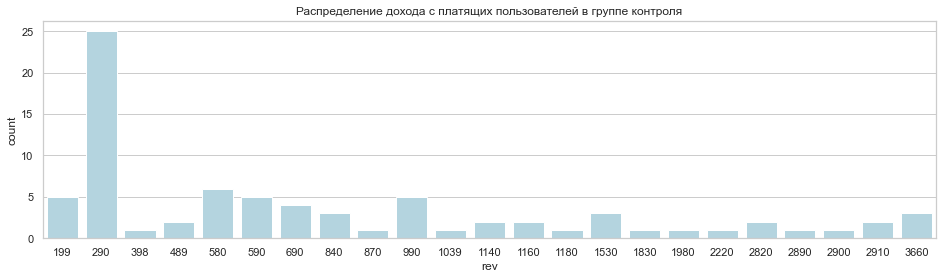

In [108]:
# Визуализируем распределение дохода с платящих пользователей в группе контроля
plt.figure(figsize=(16,4))
sns.countplot(x=act_control.rev.dropna().apply(int), color='lightblue')
plt.title("Распределение дохода с платящих пользователей в группе контроля");

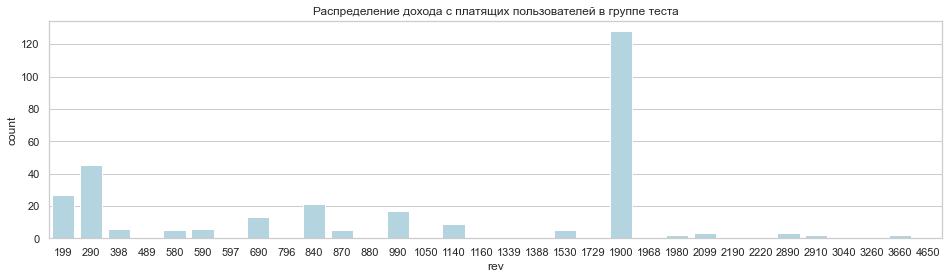

In [109]:
# Визуализируем распределение дохода с платящих пользователей в группе теста
plt.figure(figsize=(16,4))
sns.countplot(x=act_test.rev.dropna().apply(int), color='lightblue')
plt.title("Распределение дохода с платящих пользователей в группе теста");

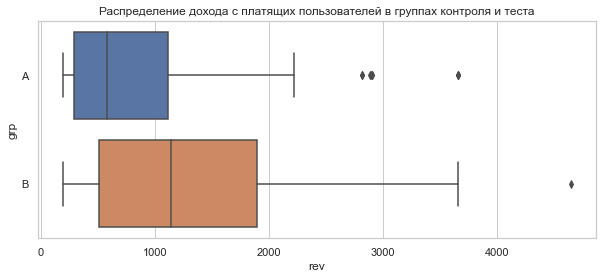

In [110]:
# Воспользуемся диаграммой боксплот для более удобного сравнительного анализа распределения дохода по платящим пользователям
sns.boxplot(data=groups_all.dropna().query("status == 'active'"), x='rev', y='grp')
plt.title("Распределение дохода с платящих пользователей в группах контроля и теста");

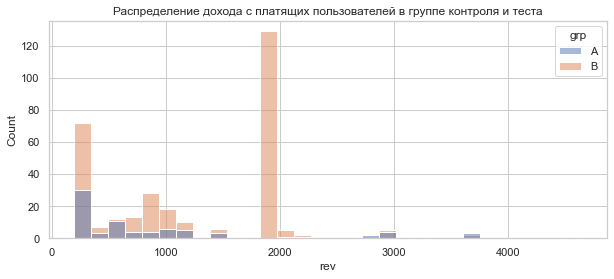

In [111]:
# Посмотрим на распределение дохода c платящих пользователей по группам на одной диаграмме
sns.histplot(data=groups_all.query('status=="active"'), x="rev", hue="grp", bins=30)
plt.title("Распределение дохода с платящих пользователей в группе контроля и теста");

In [112]:
#Основные статистики для группы теста и контроля (в том числе и по активным неплатящим пользователям)
pd.concat([act_control.fillna(0).describe().rename(columns={'rev':'A'}), \
              act_test.fillna(0).describe().rename(columns={'rev':'B'})], axis=1)

,A,B
count,1538.000000,6803.000000
mean,47.347204,58.058798
std,290.490632,313.770198
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,3660.000000,4650.000000


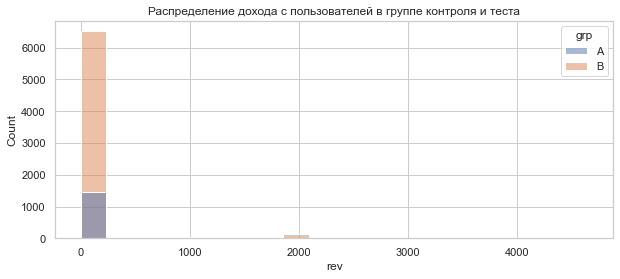

In [113]:
# Посмотрим на распределение дохода c пользователей по группам 
sns.histplot(data=groups_all.fillna(0).query('status=="active"'), x="rev", hue="grp", bins=20)
plt.title("Распределение дохода с пользователей в группе контроля и теста");

In [114]:
# Проверим тестом Левена гомогенность дисперсий в двух выборках
# pval > 0.05: Нулевая гипотеза о равенстве дисперсий принимается — дисперсии гомогенны.
# pval <= 0.05: Нулевая гипотеза отклоняется — дисперсии неоднородны

pg.homoscedasticity(data=groups_all.dropna().query('status=="active"'), dv='rev', group='grp', method='levene')

,W,pval,equal_var
levene,3.075681,0.080257,True


In [116]:
# Проверим нормальность данных (хотя уже по описательным статистикам и визуализациям итак понятно, что данные совершенно не нормальные)

# по Шапиро
display(pg.normality(data=groups_all.query('status=="active"'), dv="rev", group="grp"))

# по альтернативному тесту
display(pg.normality(data=groups_all.query('status=="active"'), dv="rev", group="grp", method="normaltest"))

,W,pval,normal
grp,,,
A,0.735324,1.498682e-10,False
B,0.854723,1.543654e-16,False


,W,pval,normal
grp,,,
A,30.378420,2.531687e-07,False
B,6.795664,3.344570e-02,False


#### Вывод

Распределение доходов с пользователей отличается от нормального. При этом размер выборок и факт того, что дисперсии в выборках гомогенны, позволяет использовать для проверки гипотез классический t-test.

### Гипотеза 2: изменился доход с активного платящего пользователя платформы

In [121]:
# Выведем для наглядности по группам кол-во платящих клиентов, суммарную выручку, ст. откл, среднее и медианное значение ARPPU 
groups_all.query('status == "active"') \
          .groupby(['grp'], as_index=False) \
          .agg(clients=('rev', 'count'), rev_total=('rev', 'sum'), rev_std=('rev', 'std'), 
               ARPPU_mean=('rev','mean'), ARPPU_median=('rev','median'))

,grp,clients,rev_total,rev_std,ARPPU_mean,ARPPU_median
0,A,78,72820.0,919.932711,933.589744,585.0
1,B,314,394974.0,790.864245,1257.878981,1140.0


In [118]:
print(f'Cредний доход на платящего пользователя в группе теста по сравнению с группой контроля увеличился на {round((act_test.rev.mean() - act_control.rev.mean())/act_control.rev.mean()*100,1)}%')

Cредний доход на платящего пользователя в группе теста по сравнению с группой контроля увеличился на 34.7%


##### Применим t-тест 

- $H_0$: средний доход с платящего пользователя, который заходил на платформу в дни проведения эксперимента, в тестовой и контрольной группе не различается  
- $H_1$: средний доход с платящего пользователя, который заходил на платформу в дни проведения эксперимента, в тестовой и контрольной группе различается  

In [119]:
# Стандартный t-test
pg.ttest(x=act_control.dropna().rev, y=act_test.dropna().rev)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.86169,106.981667,two-sided,0.00507,"[-548.94, -99.64]",0.39646,6.536,0.878211


##### Вывод 
pval < 	0.05 => **отклоняем** $H_0$  
Средний доход  с платящего пользователя, который заходил на платформу в дни проведения эксперимента, в тестовой и контрольной группе различается. 
В группе теста ARPPU стат.значимо выше.

### Гипотеза 3: изменился доход с активного пользователя 

In [122]:
# Выведем для наглядности по группам количество юзеров, суммарную выручку, стандартное отклонение, среднее и медианное значение ARPU 
groups_all.fillna(0) \
          .query('status == "active"') \
          .groupby(['grp'], as_index=False) \
          .agg(users=('id', 'count'), rev_total=('rev', 'sum'), 
               rev_std=('rev', 'std'), ARPU_mean=('rev','mean'), ARPU_median=('rev','median'))

,grp,users,rev_total,rev_std,ARPU_mean,ARPU_median
0,A,1538,72820.0,290.490632,47.347204,0.0
1,B,6803,394974.0,313.770198,58.058798,0.0


In [123]:
print(f'Cредний доход на пользователя в группе теста по сравнению с группой контроля увеличился на {round((act_test.fillna(0).rev.mean() - act_control.fillna(0).rev.mean())/act_control.fillna(0).rev.mean()*100,1)}%')

Cредний доход на пользователя в группе теста по сравнению с группой контроля увеличился на 22.6%


##### Применим t-тест 
- $H_0$: средний доход с пользователя, который заходил на платформу в дни проведения эксперимента, в тестовой и контрольной группе не различается  
- $H_1$: средний доход с пользователя, который заходил на платформу в дни проведения эксперимента, в тестовой и контрольной группе различается  

In [124]:
# Стандартный t-test
pg.ttest(x=act_control.fillna(0).rev, y=act_test.fillna(0).rev)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.286374,2416.748026,two-sided,0.198436,"[-27.04, 5.62]",0.034597,0.073,0.231965


##### Вывод
pval > 	0.05 => **НЕ отклоняем** $H_0$  
Средний доход с пользователя, который заходил на платформу в дни проведения эксперимента, в тестовой и контрольной группе не различается

### Основные выводы по эксперименту

1. Система сплитования изначально определила 14 693 пользователей в группу контроля и 59 883 пользователей в группу теста, что кажется не совсем рациональным (то есть в группу теста попало в 4 раза больше пользователей, чем в группу контроля). Все дальнейшие выводы сделаны на основании спланированного таким образом эксперимента, но есть рекомендация не раскатывать непротестированные изменения сразу на такую долю пользователей (поскольку это несет риски, если изменения окажутся негативными). Для более корректных экспериментов стоит стремиться к более сбалансированному распределению пользователей по группам.

2. По имеющимся данным можно предположить, что существуют способы обойти посещение сайта для проведения оплаты. 149 пользователей осуществили оплату без посещения сайта (29 из группы контроля, 120 из группы теста); все пользователи, которые не зашли на платформу в дни проведения эксперимента, в том числе и оплатившие, были исключены из расчета ключевых метрик по оценке эффективности новой механики оплаты.  

3. Распределение дохода с активных платящих пользователей отличается от нормального в обеих группах (что в целом отражает специфику трат пользователей в самых разных сервисах). В группе теста наблюдается статистически значимое увеличение среднего дохода на платящего пользователя на 34.7% в сравнении с контрольной группой.  

4. Снижение конверсии в оплату на 8.99% у тестовой группы, как и увеличение среднего дохода на пользователя на 22.6%, по результатам AB-тестирования нельзя считать значимыми изменениями.


Мы не знаем, в ходе тестирования какой именно продуктовой гипотезы целевой группе была предложена новая механика оплаты услуг на сайте. Таким образом:

- если повышение среднего дохода на платящего пользователя — это основная бизнес-цель эксперимента, то новая механика может быть оправдана, так как наблюдается статистически значимое увеличение метрики ARPPU. 
- если продуктовая гипотеза касалась улучшений показателей ARPU, конверсии в покупку, то по результатам AB-тестов запуск новой механики на всех пользователей не оправдан.

На текущем этапе я бы рекомендовала провести дополнительное тестирование с более оправданным распределением пользователей между группами и четко сформулированными продуктовыми целями эксперимента.

#### Дополнительные задачи по написанию функций

Реализация функции, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

In [125]:
# Аргументы функции

# base_df - основной датафрейм в работе (в нашем кейсе это groups_all)
# groups_extra_link - дополнительный файл с id юзеров и назначением групп
# active_studs_extra_link - дополнительный файл с id активных юзеров
#    пояснение: предусмотрена возможность подгрузить также и доп. файл с id активных юзеров, так как: 
#    1) статус активности необходим для id пользователей из доп.файла groups_extra_link
#    2) если эксперимент будет продолжен, то вполне вероятно изменение статуса активности у пользователя с неактивного на активный
# checks_extra_link - дополнительный файл с тратами по id юзеров
#    пояснение: предусмотрена возможность подгрузить также и доп. файл с тратами юзеров
#    1) эта информация необходима для id пользователей из доп.файла groups_extra_link
#    2) функция позволяет заменить сумму трат по id пользователя, который уже есть в основном датафрейме, если это необходимо
#   Ссылки по умолчанию groups_extra_link, active_studs_extra_link, checks_extra_link — ссылки на csv-файлы из задания

# Результат работы функции
# Словарь: по ключу 'df' можно получить обновленный датафрейм, по 'metrics' — расчет метрик


import csv
from io import StringIO

def func_add(base_df, \
             groups_extra_link=      'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ', \
             active_studs_extra_link='https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ', \
             checks_extra_link=      'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'):
    
    def func_download_files(pub_key):
        
        # Получаем ссылку для скачивания файла        
        key='https://cloud-api.yandex.net/v1/disk/public/resources/download?'
        download_url = requests.get(key + urlencode(dict(public_key=pub_key))).json()['href']   
        # Скачиваем содержимое файла и читаем содержимое файла как текст
        csv_data = requests.get(download_url).text
        # Определяем разделитель 
        try:
            detected_delimiter = csv.Sniffer().sniff(csv_data[:1024]).delimiter
        except Exception:
            detected_delimiter = ','
        # Читаем CSV в DataFrame 
        return pd.read_csv(StringIO(csv_data), sep=detected_delimiter)       
        
    # Загрузка датафреймов 
    
    groups_extra       = func_download_files(groups_extra_link)
    active_studs_extra = func_download_files(active_studs_extra_link)
    checks_extra       = func_download_files(checks_extra_link)
    
        
    # Обработка groups_extra   
    
    # Переименуем колонки и переведем в строковый формат
    groups_extra.columns = ['id', 'grp']    
    groups_extra = groups_extra.astype({'id': 'str', 'grp': 'str'})     
    # Делаем проверку и очищаем от таких ситуаций в groups_extra:
    # 1) наличие полного дубля строк
    # 2) наличие и A, и B групп на один id
    # 3) наличие повтора id из основного base_df
    # 4) наличие каких-либо еще групп, кроме A и B    
    groups_extra = groups_extra.query('~id.isin(@base_df.id) and grp in ["A", "B"]') \
                               .drop_duplicates().groupby('id').filter(lambda x: x['grp'].nunique() == 1)    
    # Объединяем base_df и отфильтрованный groups_extra
    updated_df = pd.concat([base_df, groups_extra], ignore_index=True)
    
    # Обработка active_studs_extra        
    
    # Переименуем колонки, переведем в строковый формат, сделаем проверку на дубликаты
    active_studs_extra.columns = ['id']      
    active_studs_extra['id'] = active_studs_extra['id'].astype('str')
    active_studs_extra = active_studs_extra.drop_duplicates()
    
    # Обработка checks_extra     
    
    # Переименуем колонки, переведем в строковый формат
    checks_extra.columns = ['id', 'rev']        
    checks_extra = checks_extra.astype({'id': 'str', 'rev': 'float'})    
    # Объединим траты по id юзера (в исходной задаче данные уже были агрегированы, на всякий случай)
    checks_extra = checks_extra.groupby(['id'],as_index=False).rev.sum()
    

    # Обработка updated_df 
    
    # Обновим статус активности
    updated_df['status'] = np.where(updated_df.status.isin([np.NaN, 'inactive']) \
    & updated_df.id.isin(active_studs_extra.id), 'active', updated_df.status.fillna('inactive'))    
    # Обновим статус оплаты
    updated_df['client'] = np.where(updated_df.client.isin([np.NaN, 'without paying']) \
    & updated_df.id.isin(checks_extra.id), 'paying', updated_df.client.fillna('without paying'))  
    # Обновим выручку
    updated_df['rev'] = updated_df.id.map(checks_extra.set_index('id').rev).fillna(updated_df.rev)
    
    # Рассчитаем метрики
    
    metrics = updated_df.query('status == "active"').groupby(['grp'], as_index=False) \
    .agg(users=('id', 'count'), clients=('rev', 'count'), rev_total=('rev', 'sum')) \
    .assign(CR=lambda x: round(x.clients / x.users, 4), ARPU=lambda x: round(x.rev_total / x.users, 2), \
    ARPPU=lambda x: round(x.rev_total / x.clients, 2))
    
    return {'metrics': metrics, 'df': updated_df}

Проверим корректность работы функции, запустив ее без передачи groups_extra_link, active_studs_extra_link, checks_extra_link

In [126]:
result  = func_add(groups_all)
result['metrics']

,grp,users,clients,rev_total,CR,ARPU,ARPPU
0,A,1538,78,72820.0000,0.0507,47.35,933.59
1,B,6803,314,394974.0035,0.0462,58.06,1257.88


Реализация функции, которая будет строить графики по получаемым метрикам.

In [127]:
# В качестве аргументов необходимо передать результаты работы функции func_add

def viz(df, metrics):
    sns.set(font_scale=1.8, rc={'figure.figsize':(28, 14)})    
    f, axes = plt.subplots(2, 2)
    
    # Первая диаграмма
    sns.histplot(data=df.dropna().query('status=="active"'), x="rev", hue="grp", bins=30, ax=axes[0, 0])
    axes[0, 0].set(title='ARPPU')
    for name_group in df.grp.unique():
        color = 'blue' if name_group == 'A' else 'red'
        g_mean = df.dropna().query('status == "active" & grp == @name_group').rev.mean()
        axes[0, 0].axvline(g_mean, ls='--', color=color, label=f'{name_group} mean: {g_mean:.2f}')
    axes[0, 0].legend()     
    
    # Вторая диаграмма
    sns.histplot(data=df.fillna(0).query('status=="active"'), x="rev", hue="grp", bins=30, ax=axes[0, 1])
    axes[0, 1].set(title='ARPU')
    for name_group in df.grp.unique():
        color = 'blue' if name_group == 'A' else 'red'
        g_mean = df.fillna(0).query('status == "active" & grp == @name_group').rev.mean()
        axes[0, 1].axvline(g_mean, ls='--', color=color, label=f'{name_group} mean: {g_mean:.2f}')
    axes[0, 1].legend()    
    
    # Третья диаграмма
    sns.boxplot(data=df.dropna().query("status == 'active'"), x='rev', y='grp', ax=axes[1, 0])
    axes[1, 0].set(title ="Boxplot for paying users") 
    
    # Четвертая диаграмма    
    sns.countplot(data=df.query("status == 'active'"), y='grp', ax=axes[1, 1], color='lightgrey', label='Users')
    sns.countplot(data=df.dropna().query("status == 'active'"), y='grp', color='seagreen', ax=axes[1, 1], label='Customers')
    for name_group in df.grp.unique():
        CR = df.query("status == 'active' & grp == @name_group").rev.apply(lambda x: 1 if x > 0 else 0).mean()*100
        axes[1, 1].axvline(ls='None', label=f'{name_group} CR: {CR:.2f}%')
    axes[1, 1].legend() 
    axes[1, 1].set(title='Users & customers: CR')
    plt.tight_layout()

Проверим корректность работы функции.

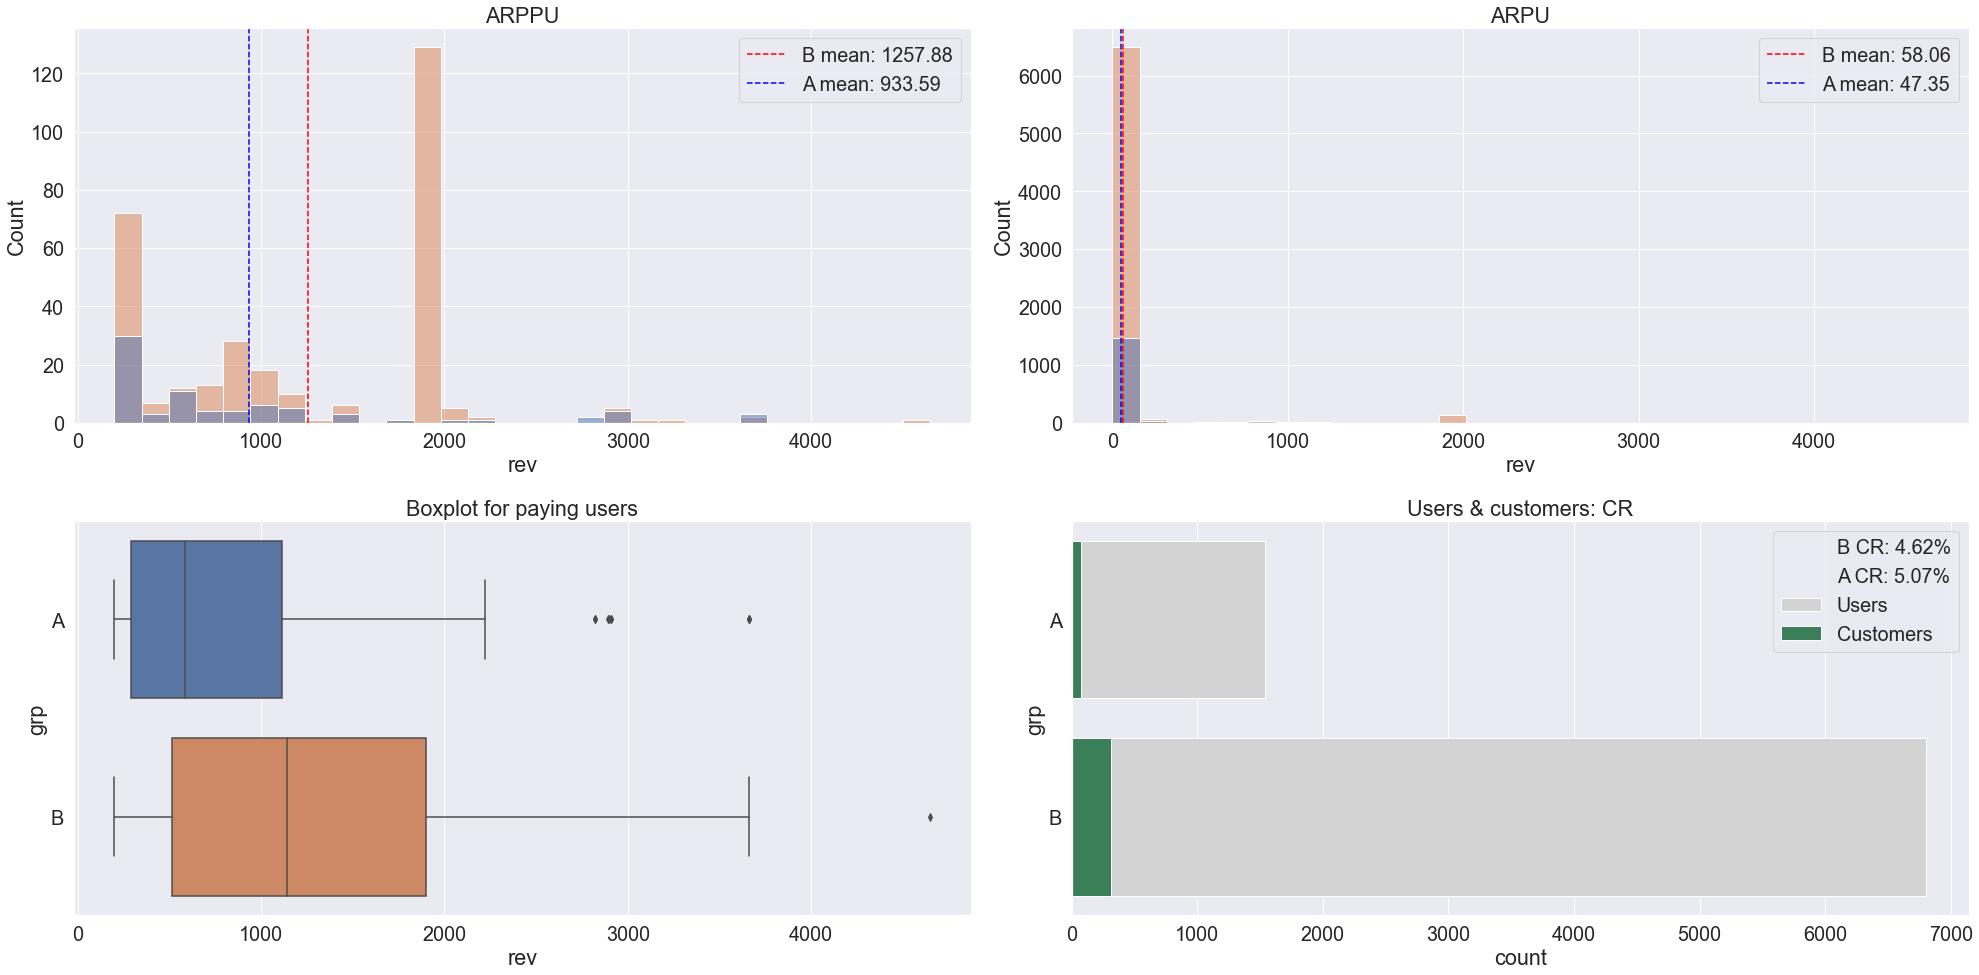

In [128]:
viz(result['df'], result['metrics'])